In [2]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import seaborn as sns
import time
from sklearn import metrics
import random

In [3]:
folder_path = f"/kaggle/working/run/"
os.makedirs(folder_path, exist_ok=True)


dataset_dir = r"/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)"

In [4]:
class_names = []
features = []
labels = []
image_size = (224, 224)

for path, subdirs, files in os.walk(dataset_dir):
    num_files = len(files)
    num_to_select = int(num_files * 0.1)
    selected_files = random.sample(files, num_to_select)
        
    for name in tqdm(selected_files):
        img_path = os.path.join(path, name)
        if img_path.endswith("png"):
            image_read = cv2.imread(img_path)
            image_resized = cv2.resize(image_read, image_size)
            image_normalized = image_resized / 255.0
            
            path_parts = path.split('/')
            label = path_parts[-1]
            
            if label not in class_names:
                class_names.append(label)
            
            features.append(image_normalized)
            index = class_names.index(label)
            labels.append(index)
                
features = np.asarray(features)
labels = np.asarray(labels)

0it [00:00, ?it/s]
100%|██████████| 2234/2234 [00:23<00:00, 93.23it/s] 


In [5]:

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [6]:
del features
del labels

In [7]:
# Hyperparameter
learning_rate = 0.001
epochs = 100
batch_size = 16

In [8]:

base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3),
)

for layer in base_model.layers :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [9]:
model_checkpoint = ModelCheckpoint(os.path.join(folder_path, f"best_model.h5"), monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger(os.path.join(folder_path, f"log.csv"), separator=',', append=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


start_time = time.time()

# Training
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[model_checkpoint, csv_logger, early_stopping],
    batch_size=batch_size,
)

# Hitung waktu training
end_time = time.time()

print(f"Training Time : {end_time - start_time}")

Epoch 1/100
183/183 [==============================] - 15s 50ms/step - loss: 2.1889 - accuracy: 0.9415 - val_loss: 0.0955 - val_accuracy: 0.9920
Epoch 2/100
183/183 [==============================] - 6s 31ms/step - loss: 0.0280 - accuracy: 0.9966 - val_loss: 0.1796 - val_accuracy: 0.9904
Epoch 3/100
183/183 [==============================] - 7s 37ms/step - loss: 0.1669 - accuracy: 0.9836 - val_loss: 0.0816 - val_accuracy: 0.9952
Epoch 4/100
183/183 [==============================] - 6s 32ms/step - loss: 0.0362 - accuracy: 0.9956 - val_loss: 0.1372 - val_accuracy: 0.9888
Epoch 5/100
183/183 [==============================] - 7s 38ms/step - loss: 0.0583 - accuracy: 0.9952 - val_loss: 0.0041 - val_accuracy: 0.9984
Epoch 6/100
183/183 [==============================] - 7s 39ms/step - loss: 0.0197 - accuracy: 0.9979 - val_loss: 3.3504e-04 - val_accuracy: 1.0000
Epoch 7/100
183/183 [==============================] - 6s 31ms/step - loss: 0.0236 - accuracy: 0.9983 - val_loss: 0.7601 - val_accu

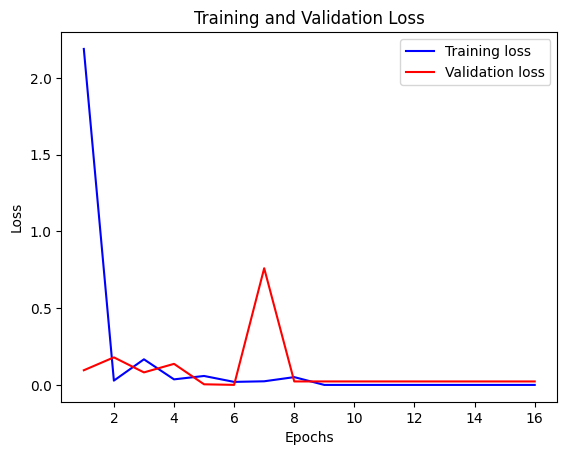

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss.png'))
plt.show()

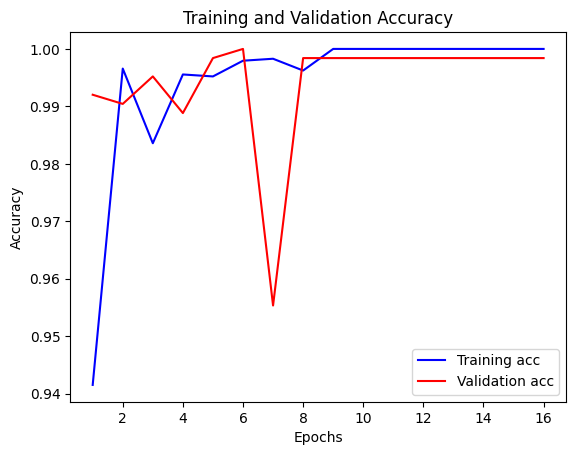

In [11]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy.png'))
plt.show()

In [12]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

with open(os.path.join(folder_path, 'classification_report.txt'), 'w') as file:
    file.write(classification_rep)

20/20 [==============================] - 3s 62ms/step
Classification Report:
               precision    recall  f1-score   support

  Non Drowsy     0.9968    0.9968    0.9968       308
      Drowsy     0.9969    0.9969    0.9969       319

    accuracy                         0.9968       627
   macro avg     0.9968    0.9968    0.9968       627
weighted avg     0.9968    0.9968    0.9968       627



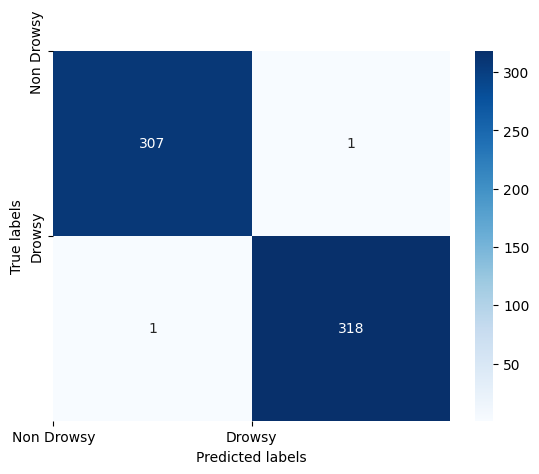

In [13]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(os.path.join(folder_path, 'confusion matrix.png'))
plt.show()